### TODO
* copy in other file
* find unused code
* doublecheck zeropoints
* doublecheck catalogue
* check folder - a temp data folder
* catalogue referencing later is not with variablized
* update planck cosmology

In [24]:
catalogue = "gds/jades/phot/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog_large_withSpec.fits"
cat_out_name = "gds_jwst_nircam_large_withSpec"
# template names and paths

ftempl_labeldict = {#! use ; to indicate modifications
    'fsps_45k;linearcomb': "F45k;LC",
    'fsps_45k;0.3removed': "F45k;0.3r",
    'EMLines;linearcomb': "EMLi;LC",
    'EMextreme': "EMEx",
    'EMlines': "EMLi",
    'fsps_45k': "F45k",
    'fsps_60k': "F60k",
    'carnall_sfhz_13': "CASFH",
    'corr_sfhz_13': "COSFH",
    'blue_sfhz_13': "BLSFH",
    #"EAZL",
    'eazy_v1.3.spectra': "EAZ3",
    #"BR07",
    #"PEG",
    #"PEG13",
    #"CWWK"
}

In [25]:
##################### READ IN TEMPLATES #####################
import os
ftempl_strs = []
ftempl_labels = []
for f in os.listdir("templates2test"):
    if f.endswith(".param"):
        templ_str = f.split(".param")[0]
        ftempl_strs.append(templ_str)
        try:
            ftempl_labels.append(ftempl_labeldict[templ_str])
        except KeyError:
            raise KeyError("No label for template: ", templ_str)
    else: continue
    print("Found template: ", templ_str)
    print("Label: ", ftempl_labeldict[templ_str])
    print("")

Found template:  fsps_45k;0.3removed
Label:  F45k;0.3r

Found template:  corr_sfhz_13
Label:  COSFH

Found template:  fsps_60k
Label:  F60k

Found template:  EMextreme
Label:  EMEx

Found template:  blue_sfhz_13
Label:  BLSFH

Found template:  carnall_sfhz_13
Label:  CASFH

Found template:  eazy_v1.3.spectra
Label:  EAZ3

Found template:  EMlines
Label:  EMLi

Found template:  EMLines;linearcomb
Label:  EMLi;LC

Found template:  fsps_45k
Label:  F45k

Found template:  fsps_45k;linearcomb
Label:  F45k;LC



In [26]:
import eazy
from eazy import filters, utils

#import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import numpy as np
import pandas as pd

#import pandas as pd
import time
import os
from math import ceil#, floor
from copy import deepcopy as copy
import shutil
from astropy import units as u
from astropy.cosmology import Planck18
from astropy.io import fits
from astropy.table import Table, join#, hstack
from IPython.utils import io
from tqdm import tqdm
#from astropy.visualization import ZScaleInterval as zs
#from astroquery.mast import Observations as obs
#from IPython.utils import io
#from matplotlib.transforms import Affine2D
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import eazy_routines as ez
import helper_module as hmod

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs()
    for f in os.listdir("templates2test"):
        shutil.copy("templates2test/"+f, "templates/"+f, follow_symlinks=True, exist_ok=True)


cosmo = Planck18
del Planck18

plt.style.use('seaborn-v0_8-colorblind')

if "temp" not in os.listdir():
    os.mkdir("temp")

In [27]:
# log all camera filters
flt = eazy.filters.FilterFile()

filts_nircam = {
    'F090W': 363,
    'F115W': 364,
    'F150W': 365,
    'F182M': 370,
    'F200W': 366,
    'F210M': 371,
    'F277W': 375,
    'F335M': 381,
    'F356W': 376,
    'F410M': 383,
    'F430M': 384,
    'F444W': 358,
    'F460M': 385,
    'F480M': 386
}

filts_HST = {
    'F105W': 202,
    'F125W': 203,
    'F140W': 204,
    'F160W': 205,
    'F435W': 233,
    'F606W': 214,
    'F775W': 216,
    'F814W': 239,
    'F850LP': 240        
}

filts_wavelengths = {#!actually check
}
res = filters.FilterFile('FILTER.RES.latest')
for f in res.filters:
    for filt in filts_nircam | filts_HST:
        if filt.lower() in f.name:
            filts_wavelengths[filt] = {
                'mean': f.pivot,
                'width': f.rectwidth
                }
            break

filts = {**filts_nircam, **filts_HST}
del filts_HST, filts_nircam

mw_reddening = ez.get_atten_dict(filts)#!is used?

# get zeropoints
zps = [1.0]*len(filts)#!should be evaluated if this is correct

In [28]:
#=== load data
#inname = "hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog.fits"
inname = catalogue.split('/')[-1]
inpath = os.path.join(os.getenv('astrodata'), catalogue)

# print the meta info
with fits.open(inpath) as hdul:
    print(hdul.info())

# load photometry table
tab = Table.read(inpath, hdu=6)
tab_redshifts = Table.read(inpath, hdu=9)

#=== make EAZY table

# load fluxes
# CIRC1: 0.10 arcsec aperture (see README)
ext = '_CIRC1'
cols_dummy = hmod.get_matches(ext, tab.columns, exclude='_ei')
cols_f = np.sort(hmod.get_matches(ext, cols_dummy, exclude='_e'))
cols_fe = np.sort(hmod.get_matches('_e', cols_dummy))
cols_fluxes = list(np.vstack([cols_f, cols_fe]).T.flatten())
cols = list(np.insert(cols_fluxes, 0, ['ID', 'RA', 'DEC', 'z_spec']))
del cols_dummy

tab = join(tab, tab_redshifts['ID', 'z_spec'], join_type='inner', keys='ID')
tab_out = tab[cols]

# convert from nJy to uJy
# and apply MW reddening
keys = np.array(list(mw_reddening.keys()))
for c in cols_fluxes:
    tab_out[c].unit = u.nJy
    tab_out[c] = tab_out[c].to(u.uJy)
    
    # apply MW reddening
    matches = hmod.get_matches(keys, c, get_idxs=True)
    key = keys[np.int32(matches[:,0])][0]
    tab_out[c] *= mw_reddening[key]
del c, keys, key, matches

# redshift limit
zmin = 1.0
for i in range(len(tab_out)):
    if tab_out['z_spec'][i] < zmin:
        tab_out['z_spec'][i] = -1.0
    
# rename columns
for c in cols_f:
    cnew = c.replace(ext, '_flux')
    tab_out.rename_column(c, cnew)
del c, cnew

for c in cols_fe:
    cnew = c.replace(ext+'_e', '_err')
    tab_out.rename_column(c, cnew)
del c, cnew

#=== apply MW reddening
#atten_dict = ez.get_atten_dict(filts_eazyres, filts_str)
#degr_image_sig *= atten_dict[filt] / 100. # uJy

# save EAZY table
tab_out.write(f'temp/{cat_out_name}.fits', format='fits', overwrite=True)
del tab_out, tab, tab_redshifts

Filename: /home/ubuntu-compute/Desktop/astrodata/gds/jades/phot/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog_large_withSpec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   ()      
  1  FILTERS       1 BinTableHDU     33   23R x 12C   [6A, E, E, E, E, E, E, E, E, E, E, E]   
  2  FLAG          1 BinTableHDU    161   1429R x 75C   [J, D, D, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E]   
  3  SIZE          1 BinTableHDU    100   1429R x 43C   [J, D, D, E, D, D, D, D, J, J, J, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  4  CIRC          1 BinTableHDU    856   1429R x 423C   [J, D, D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E,

None


In [29]:
runTime = int(time.time())

In [30]:
#=== set up paths for eazy

# catalog paths
cat_path = f'temp/{cat_out_name}.fits'
keys_id = ['ID id', 'RA ra', 'DEC dec', 'z_spec z_spec']



templ_paths = [f"templates/{e}.param" for e in ftempl_strs]
out_names = [f for f in ftempl_strs]
out_paths = [f"eazy-output/{f}_{runTime}" for f in out_names]
#paths = np.array([templ_paths, out_paths]).T

In [31]:
##################### PHOTOZ OBJECT CONFIG #####################
paramsSet = []
for tpath, opath, oname in zip(templ_paths, out_paths, out_names):
    params = {
        "cat_path": cat_path,
        "templ_path": tpath,
        "out_path": opath,
        "FIX_ZSPEC": 'n',
        "USE_ZSPEC_FOR_REST": 'n',
        "Z_MAX": 12.0,
        "H0": cosmo.H0,
        "OMEGA_M": cosmo.Om0,
        "OMEGA_L": cosmo.Ode0,
        "CATALOG_FORMAT": 'fits',
        'VERBOSE': 'y'}
    paramsSet.append(params)
paramsDict = dict(zip(out_names, paramsSet))
del tpath, opath, oname, params, paramsSet

In [32]:
##################### RUN EAZY #####################
if True: raise UserWarning("This will run EAZY. Set to False to avoid this.")
# iterate over tempalte sets
photZs = []
for tpath, opath, oname in zip(templ_paths, out_paths, out_names):

    params = paramsDict[oname]
    
    # write eazy config files
    filt_num, fnames = ez.write_config(f'{cat_out_name}_{oname}', filts, zps, keys_id,
                                       out_path=opath)

    # run eazy
    #idx = np.array([0])
    idx = None
    #zout, hdu = ez.run_eazy(params, fnames, n_proc=-1, idx=idx)
    #from eazy import photoz
    #from eazy import templates
    #from eazy import filters
    #from eazy import utils
    #photZ = photoz.PhotoZ(param_file=tpath, translate_file='gds_jades_eazy.zphot.translate', zeropoint_file=None,
    #                        params=params)
    #photZ.fit_parallel(n_proc=-1, idx=idx)
    pz = ez.eazy_init_photoz(params,
                                ftran=fnames['ftran'],
                                fzp=fnames['fzp'])
    pz.fit_catalog(idx=idx, n_proc=-1, verbose=True, get_best_fit=True)
    tbl, hdu = pz.standard_output(#UBVJ=None,#percentile_limits=[],#!some bug bug preventing me from removing UBVJ,percentile_limits
                                        extra_rf_filters=filt_num,#!set pad_width=0 and max_err=0 maybe??
                                        save_fits=2)
    tbl.write(f'{opath}/out_eazy.fits', format='fits', overwrite=True)
                                  
    #break
    #print(chi2_fit)
    #print(fit_coeffs)
    #zout, __ = ez.run_eazy(params, fnames, n_proc=-1, idx=idx)
    #photZs.append(zout)
    del idx, params, filt_num, fnames, tpath, opath, oname

UserWarning: This will run EAZY. Set to False to avoid this.

In [33]:
#find latest runTime in folder:
runtimeNum = -2
runTimes = np.sort([int(f.split('_')[-1]) for f in os.listdir('eazy-output') if f != '.gitignore'])
runTimes = np.unique(runTimes)
runTime = int(runTimes[runtimeNum])
outpaths_f = 'eazy-output/{ftempl}_{runTime}/' + cat_out_name + '.zout.fits'
print("Picking runTime:", runTime)
del runTimes, runtimeNum
out_paths = [os.path.dirname(outpaths_f.format(ftempl=f, runTime=runTime)) for f in ftempl_strs]

Picking runTime: 1697460987


In [34]:
maxLen = 3
out_paths = out_paths[:maxLen]
ftempl_strs = ftempl_strs[:maxLen]
out_names = out_names[:maxLen]
templ_paths = templ_paths[:maxLen]
ftempl_labels = ftempl_labels[:maxLen]

In [35]:
##################### EAZY PHOTZ OBJECT DATA #####################
#pack all usefull data
#if input("Press Enter to continue...") != "": raise UserWarning("This will load the photZ objects...")
if False: raise UserWarning("This will run EAZY. Set to False to avoid this.")
photZs = {}

photZs['output_df'] = {}
for tpath, opath, oname, ftempl in zip(templ_paths, out_paths, out_names, ftempl_strs):
    tbl = Table.read(opath + '/' + cat_out_name + '.zout.fits')
    restPhot = {key: tbl[key] for key in tbl.keys() if key.startswith('rest')}
    photVals = {int(key.split('rest')[-1]): tbl[key] for key in tbl.keys() if key.split('rest')[-1].isnumeric()}
    photErrs = {int(key.split('rest')[-1].split("_")[0]): tbl[key] for key in tbl.keys() if key.split('rest')[-1].split("_")[0].isnumeric() and key.endswith('err')}
    usefullColls = {
        'ID': tbl['id'],
        'z_spec': tbl['z_spec'],
        'z_phot': tbl['z_phot'],
        'z_phot_chi2': tbl['z_phot_chi2'],
        'z_phot_risk': tbl['z_phot_risk']
    }
    for filt in photVals.keys():
        usefullColls[f'{filt}_val'] = photVals[filt]
        usefullColls[f'{filt}_err'] = photErrs[filt]
    photZs['output_df'][ftempl] = Table(
        data = [d for d in usefullColls.values()],
        names = [d for d in usefullColls.keys()]
    )

photZs['output_pz'] = {}
for tpath, opath, oname, ftempl in tqdm(zip(templ_paths, out_paths, out_names, ftempl_strs),desc="Loading PHOTZ and gridding templatespace...", total=len(templ_paths)):
    params = {"cat_path": cat_path,
            "templ_path": tpath,
            "out_path": opath,
            "FIX_ZSPEC": 'n',
            "USE_ZSPEC_FOR_REST": 'n',
            "Z_MAX": 12.0,
            "H0": cosmo.H0,
            "OMEGA_M": cosmo.Om0,
            "OMEGA_L": cosmo.Ode0,
            "CATALOG_FORMAT": 'fits',
            'VERBOSE': 'n'}

    # write eazy config files
    filt_num, fnames = ez.write_config(cat_out_name + '.zphot', filts, zps, keys_id,
                                        out_path=opath, fwrite=False)

    # get a photoz object
    with io.capture_output() as captured: # capture output
        pz = ez.eazy_init_photoz(params, **fnames)
        photZs['output_pz'][ftempl] = pz

photZs['input_df'] = {}
for tpath, opath, oname, ftempl in zip(templ_paths, out_paths, out_names, ftempl_strs):#read input catalog and put it in a pandas dataframe
    tbl = Table.read(opath + '/' + 'out_eazy' + '.fits')
    names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
    df = tbl[names].to_pandas()
    photZs['input_df'][ftempl] = df

photZs['input_pz'] = {}
for tpath, opath, oname, ftempl in tqdm(zip(templ_paths, out_paths, out_names, ftempl_strs),desc="Loading PHOTZ and gridding templatespace...", total=len(templ_paths)):
    params = paramsDict[oname]
    #params['cat_path'] = opath + '/' + cat_out_name + '.zout.fits'
    #params['cat_path'] = opath + '/' + 'out_eazy' + '.fits'
    
    # write eazy config files
    filt_num, fnames = ez.write_config(f'{cat_out_name}_{oname}', filts, zps, [],
                                       out_path=opath, fwrite=False)
    
    # get a photoz object
    with io.capture_output() as captured: # capture output
        pz = ez.eazy_init_photoz(
            params, fparam=opath + '/' + cat_out_name + '.zphot.param',
            **fnames)
        photZs['input_pz'][ftempl] = pz


del tpath, opath, oname, ftempl, params, filt_num, fnames

Loading PHOTZ and gridding templatespace...:   0%|          | 0/3 [00:00<?, ?it/s]

Loading PHOTZ and gridding templatespace...: 100%|██████████| 3/3 [03:28<00:00, 69.42s/it]


/tmp/ipykernel_7276/1245011538.py:49: RuntimeWarning: divide by zero encountered in divide
  deltaZ_all = (redshiftTbl['z_phot'] - redshiftTbl['z_spec'])/(1 + redshiftTbl['z_spec'])
/tmp/ipykernel_7276/1245011538.py:49: RuntimeWarning: invalid value encountered in divide
  deltaZ_all = (redshiftTbl['z_phot'] - redshiftTbl['z_spec'])/(1 + redshiftTbl['z_spec'])


/tmp/ipykernel_7276/1245011538.py:49: RuntimeWarning: divide by zero encountered in divide
  deltaZ_all = (redshiftTbl['z_phot'] - redshiftTbl['z_spec'])/(1 + redshiftTbl['z_spec'])


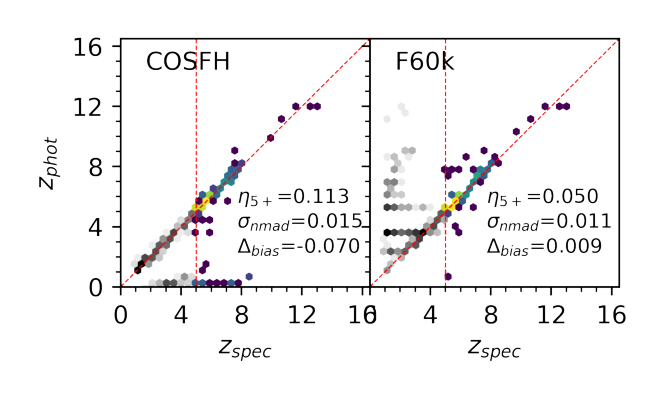

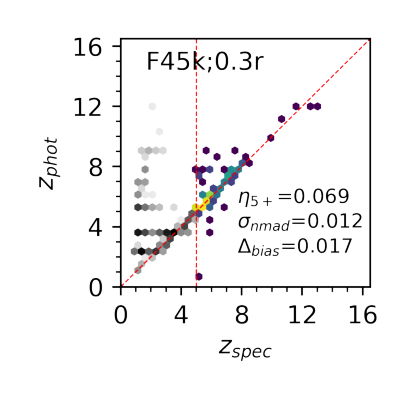

In [36]:
##################### PLOT REDSHIFT OUTPUT #####################
#TODO: needs tiling color by accumulative flux
mosTiling = 4
zMax = 16.5
mm = 1/25.4
figwidth = 183*mm
DPI = 500
zCharacteristic = 5

for mode in ['default', 'modified']:
    mode_ftempl_lbls = copy(ftempl_labels)
    mode_ftempl_strs = copy(ftempl_strs)
    if mode == 'modified': 
        mode_ftempl_lbls = [s for s in mode_ftempl_lbls if ";" in s]
        mode_ftempl_strs = [s for s in mode_ftempl_strs if ";" in s]
    if mode == 'default': 
        mode_ftempl_lbls = [s for s in mode_ftempl_lbls if ";" not in s]
        mode_ftempl_strs = [s for s in mode_ftempl_strs if ";" not in s]

    
    mosaicLen = ceil(len(mode_ftempl_lbls)/mosTiling)
    
    figsize = (1*figwidth,1*figwidth/mosTiling*mosaicLen)
    tiling = (mosaicLen,mosTiling)
    if len(mode_ftempl_lbls) < mosTiling:
        figsize = (1*figwidth/mosTiling*len(mode_ftempl_lbls),1*figwidth/mosTiling)
        tiling = (1,len(mode_ftempl_lbls))

    figMos, axsMos = plt.subplots(*tiling, figsize=figsize, dpi=DPI, facecolor=(1,1,1,0))
    #transpose and flatten
    if len(mode_ftempl_lbls) > 1:
        #axsMos = axsMos.T
        axsMos = axsMos.flatten()
    else:
        axsMos = [axsMos]
    plt.subplots_adjust(wspace=0, hspace=0)
    for i, ftempl in enumerate(mode_ftempl_strs):
        if ftempl not in photZs['output_df'].keys():
            continue
        redshiftTbl = photZs['output_df'][ftempl]
        redChar = {
            'z_spec': np.array(redshiftTbl['z_spec']),
            'z_phot': np.array(redshiftTbl['z_phot']),
        }
        mask = (redChar['z_spec'] > zCharacteristic) & (~np.isnan(redChar['z_spec'])) & (~np.isnan(redChar['z_phot']) & (redChar['z_phot'] > 0))
        redChar['z_spec'] = redChar['z_spec'][mask]
        redChar['z_phot'] = redChar['z_phot'][mask]
        deltaZ = (redChar['z_phot'] - redChar['z_spec'])/(1 + redChar['z_spec'])
        deltaZ_all = (redshiftTbl['z_phot'] - redshiftTbl['z_spec'])/(1 + redshiftTbl['z_spec'])
        outliers = (deltaZ > 0.15) | (deltaZ < -0.15)
        outliers_all = (deltaZ_all > 0.15) | (deltaZ_all < -0.15)
        bias = np.mean(deltaZ)
        scatter = np.std(deltaZ)


        #outpath = outpaths.format(ftempl=ftempl, runTime=runTime)

        """#find light intensities
        ids = df_props['id'].values
        filtTab = Table.read(inpath, hdu=4)
        #get values ending with "CIRC1"
        pointIDs = filtTab['ID']
        filtTab = filtTab[[f for f in filtTab.colnames if f.endswith('CIRC1')]]
        #get dictionary version of table
        filtTab = filtTab.to_pandas()
        keys = filtTab.keys()
        fluxes = np.array([np.array(filtTab[key]) for key in keys]).T
        pointIntensities = np.sum(fluxes, axis=1)"""

        """#clear up bad ids and make simular sort
        for j,id in list(enumerate(ids))[::-1]:
            if id not in df_props['id'].values:
                pointIntensities = np.delete(pointIntensities, j)
                ids = np.delete(ids, j)
        #sort pointIntensities and ids to match df_props
        pointIntensities = pointIntensities[np.argsort(ids)]
        ids = np.sort(ids)
        antiSort = np.argsort(df_props['id'].values)
        sort = np.argsort(antiSort)
        pointIntensities = pointIntensities[sort]
        ids = ids[sort]"""
        #Remove sub zero and nan
        mask_cur = (redshiftTbl['z_spec'] > 0) & (~np.isnan(redshiftTbl['z_spec'])) & (~np.isnan(redshiftTbl['z_phot']))
        x = np.array(redshiftTbl['z_spec'])
        y = np.array(redshiftTbl['z_phot'])
        #above = y > x + (1 + x) * 0.15 # outliers
        #below = y < x - (1 + x) * 0.15
        #outlier = above | below
        #mask_in = mask_cur & (~outlier)
        x = x[mask_cur]
        y = y[mask_cur]
        #mask_out = mask_cur & outlier
        #chi2_fit = redshiftTbl['z_phot_chi2'][mask_cur]/len(redshiftTbl.keys())#!new
        #avgchi2_fit = np.mean(chi2_fit)
        #medchi2_fit = np.median(chi2_fit)
        
        #avgchi2_fit_in = redshiftTbl['z_phot_chi2'][mask_in]/len(x)#!new
        #c = np.log10(pointIntensities[mask_cur])*((x/(1+x))**2)#!quilitative reshift scaling
        #c = np.ones(len(x))

        #calculate chi2 with linear regression of x and y
        chi2 = np.sum((y - x)**2/1)/len(x)#/len(x)#!dunno what to put for sigma

        xmin, xmax = np.c_[[x, y]].min(), np.c_[[x, y]].max()

        #axsMos[i].scatter(x, y, s=2.0, color='k')
        #hexbin with colorbar
        #axsMos[i].hexbin(x, y, gridsize=30, mincnt=1, edgecolors='none', bins='log')
        underCharc = (x < zCharacteristic)
        axsMos[i].hexbin(x[underCharc], y[underCharc], gridsize=30, mincnt=1, edgecolors='none', bins='log', cmap='Greys', extent=[xmin, xmax, xmin, xmax])#TODO: choose cmap to something that doesn't blend in with the background
        axsMos[i].hexbin(redChar['z_spec'], redChar['z_phot'], gridsize=30, mincnt=1, edgecolors='none', bins='log', extent=[xmin, xmax, xmin, xmax])

        #plt.colorbar(axsMos[i].collections[0], ax=axsMos[i], label='log$_{10}$(N)')
        axsMos[i].plot([0, 100], [0, 100], c='r', ls='--', lw=0.5)
        axsMos[i].plot([zCharacteristic, zCharacteristic], [0, 100], c='r', ls='--', lw=0.5)
        
        #dict_stat = hmod.phot_spec_zs_stats(y, x)

        #annotate in top left
        annotAnchor = (0.05, 0.95)
        #axsMos[i].set_title(f'{ftempl}', fontsize=10)
        ax, ay = 10, 95        
        axsMos[i].annotate(f'{mode_ftempl_lbls[i]}', xy=annotAnchor, xycoords='axes fraction', fontsize=10, ha='left', va='top', xytext=(ax, ay), textcoords='axes points')

        #stats annotate
        sx, sy = 37, -55
        axsMos[i].annotate(f'$\eta_{{5+}}$={round(outliers.sum()/len(outliers),3):.3f}', xy=annotAnchor, xycoords='axes fraction', fontsize=8, ha='left', va='top', xytext=(ax+sx, ay+sy), textcoords='axes points')
        if mode_ftempl_lbls[i] == 'F45k' or mode_ftempl_lbls[i] == 'F60k': asterix = '*'
        else: asterix = ''
        #axsMos[i].annotate(f'$\eta_{{0+}}$={round(outliers_all.sum()/len(outliers_all),2):.2f}{asterix}', xy=annotAnchor, xycoords='axes fraction', fontsize=8, ha='left', va='top', xytext=(ax+sx, ay+sy-10), textcoords='axes points')
        axsMos[i].annotate(f'$\sigma_{{nmad}}$={round(np.median(np.abs(deltaZ[~outliers] - np.median(deltaZ[~outliers])))*1.4826,3):.3f}', xy=annotAnchor, xycoords='axes fraction', fontsize=8, ha='left', va='top', xytext=(ax+sx, ay+sy-10), textcoords='axes points')
        axsMos[i].annotate(f'$\Delta_{{bias}}$={round(bias,3):.3f}', xy=annotAnchor, xycoords='axes fraction', fontsize=8, ha='left', va='top', xytext=(ax+sx, ay+sy-20), textcoords='axes points')


        axsMos[i].set_xlim(0,zMax)
        axsMos[i].set_ylim(0,zMax)

        axsMos[i].xaxis.set_minor_locator(MultipleLocator(1))
        axsMos[i].yaxis.set_minor_locator(MultipleLocator(1))
        axsMos[i].xaxis.set_major_locator(MultipleLocator(4))
        axsMos[i].yaxis.set_major_locator(MultipleLocator(4))

        if i % mosTiling != 0: axsMos[i].set_yticklabels([])
        else: axsMos[i].set_ylabel('$z_{phot}$', fontsize=10)
        if i < len(mode_ftempl_lbls)-mosTiling: axsMos[i].set_xticklabels([])
        else: axsMos[i].set_xlabel('$z_{spec}$', fontsize=10)

    for i in range(len(axsMos)):
        if i > len(mode_ftempl_lbls)-1:
            axsMos[i].axis('off')

    """if len(ftempl_strs) % 3 != 0:
        axsMos[-1].axis('off')
    if len(ftempl_strs) % 3 == 1:
        axsMos[-2].axis('off')"""

    #axis label
    #figMos.text(0.5, 0.05, '$z_{spec}$', ha='center', va='center')
    #figMos.text(0.05, 0.5, '$z_{phot}$', ha='center', va='center', rotation='vertical')

    figMos.savefig(f'./figures/zs_mosaic_{mode}.png', dpi=DPI, bbox_inches='tight', transparent=True)
    figMos.clf()
    plt.close(figMos)
    #show by loading image
    img = plt.imread(f'./figures/zs_mosaic_{mode}.png')
    fig = plt.figure(figsize=(1*figwidth,1*figwidth/mosTiling*mosaicLen), dpi=200, facecolor=(1,1,1,0))
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax.imshow(img)


In [37]:
##################### REDSHIFT PERFORMANCE METRICS #####################
#TODO: create a pandas dataframe over bias, scatter, so on
#TODO: both print it out here and make a latex table for the paper

fsps_45k;0.3removed
corr_sfhz_13
fsps_60k


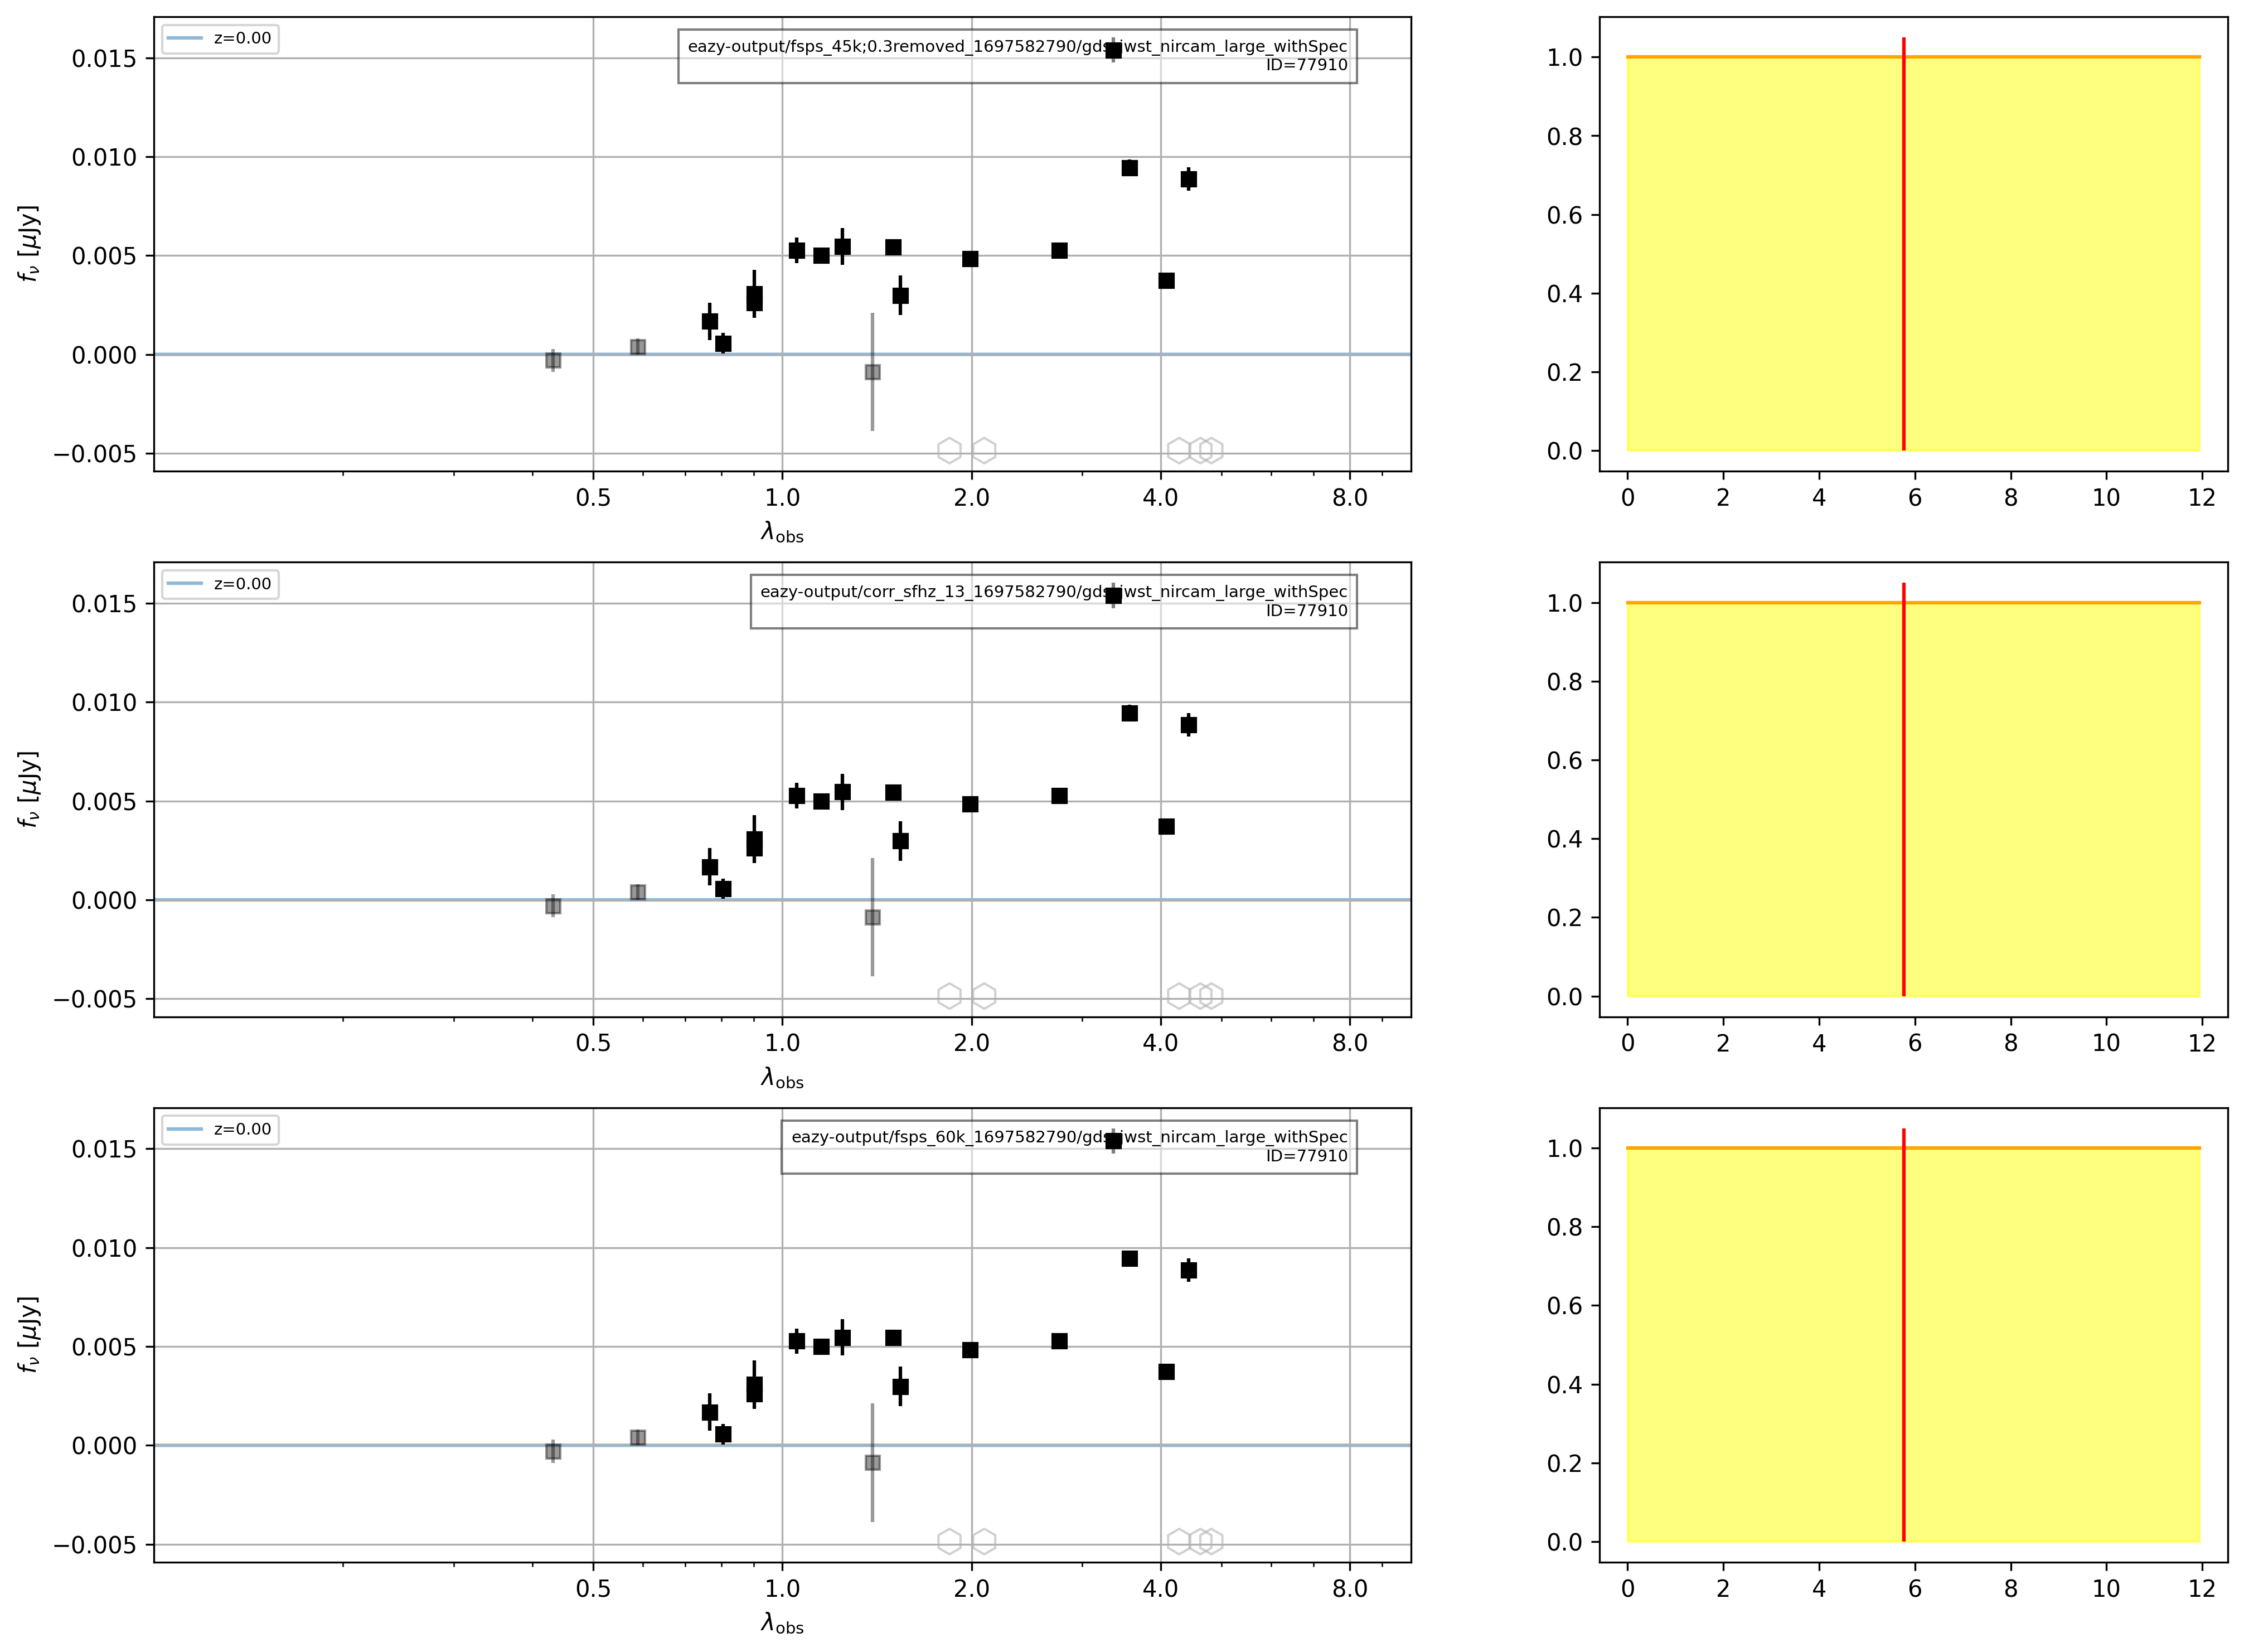

In [38]:
##################### PLOT RESTFRAME SEDS #####################
fig, axss = plt.subplots(len(ftempl_strs), 2, figsize=(16, 4*len(ftempl_strs)), dpi=300, width_ratios=[2, 1])
if len(axss.shape) == 1:
    axss = np.array([axss])
for i, df_in, pz_in, df_out, pz_out, ftempl in zip(range(len(ftempl_strs)), photZs['input_df'].values(), photZs['input_pz'].values(), photZs['output_df'].values(), photZs['output_pz'].values(), ftempl_strs):
    print(ftempl)
    #axs = axss[i]
    
    id_cat = pz_in.OBJID[0]
    
    #axs = axs.flatten()
    pz_in.show_fit(id=id_cat, add_label=True, axes=axss[i],#!tje addition of axes, removes all the settings
        show_components=False,
        #zshow=z_phot,
        xlim=[0.1, 10.0], 
        showpz=True, logpz=True, zr=[0, 12],
        show_missing=True,
        show_stars=False, snr_thresh=1.0,
        show_fnu=True,
        with_tef=True
        )#maglim=[]
    """axss[i][0].set_ylabel(ylabel)
        
    #axss[i][0].set_xlim(xlim)
    xlim = axss[i][0].get_xlim()
    xt = np.array([0.1, 0.5, 1, 2, 4, 8, 24, 160, 500])*1.e4

    axss[i][0].semilogx()

    valid_ticks = (xt > xlim[0]*1.e4) & (xt < xlim[1]*1.e4)
    if valid_ticks.sum() > 0:
        xt = xt[valid_ticks]
        axss[i][0].set_xticks(xt/1.e4)
        axss[i][0].set_xticklabels(xt/1.e4)

    axss[i][0].set_xlabel(r'$\lambda_\mathrm{obs}$')
    axss[i][0].grid()
    
    txt = '{0}\nID={1}'
    txt = txt.format(ftempl, 
                        id_cat) #, self.prior_mag_cat[ix])
                        
    axss[i][0].text(0.95, 0.95, txt, ha='right', va='top', fontsize=7,
            transform=axss[i][0].transAxes, 
            bbox=dict(facecolor='w', alpha=0.5), zorder=10)
    
    axss[i][0].legend(fontsize=7, loc='upper left')"""
    #axss[i][0].set_xlim(0.1, 5)
plt.show()

In [39]:
##################### PLOT RESTFRAME SEDS ##################### DOES NOT WORK SINCE THERE IS NO TRANSLATION FROM ZOUT FILTER VALUES TO WAVELENGTHS :(
#! WIP
#take the 10 worst chi2 and 10 best chi2
#for now, just plot restframe photometry
for key in photSets.keys():
    tbl = photSets[key]
    chi2s = tbl['chi2']
    sort = list(np.argsort(chi2s))
    include = [0,len(sort)//2,-1]
    sort = np.array(sort)[include]
    del include

    phot_vals = np.array([np.array(tbl[key]) for key in tbl.keys() if key.startswith('rest') and "err" not in key])
    phot_errs = np.array([np.array(tbl[key]) for key in tbl.keys() if key.startswith('rest') and key.endswith('err')])
    filterNums = np.array([int(key.split('rest')[-1]) for key in tbl.keys() if key.startswith('rest') and "err" not in key and 'U' not in key and 'B' not in key and 'V' not in key and 'J' not in key])
    #get filter names
    filterNames = []
    for filt in filterNums:
        for fkey in filts.keys():
            if filts[fkey] == filt:
                filterNames.append(fkey)
                break

    chi2s = chi2s[sort]
    phot_vals = phot_vals.T[sort]
    phot_errs = phot_errs.T[sort]

    #plot
    fig, axs = plt.subplots(len(sort),1,figsize=(5,4), dpi=200, facecolor=(1,1,1,0))
    #set title
    axs[0].set_title(rf'{key} - best,middle,worst $\chi^2$')
    for i in range(len(sort)):
        axss[i][0] = axs[i]
        axss[i][0].set_xscale('log')
        axss[i][0].set_yscale('log')

        axss[i][0].set_xlabel('Wavelength [micron]')
        axss[i][0].set_ylabel('Flux [uJy]')#! doublecheck
        
        axss[i][0].grid(True, which='both', alpha=0.5)#!todo actually find the proper wavelengths for the filters
        wave = np.array([filts_wavelengths[filt]['mean'] for filt in filterNames])
        print(wave)
        axss[i][0].errorbar(wave,phot_vals[i], phot_errs[i], ls='', marker='.', ms=2.0, color='k', alpha=0.5)
    fig.savefig(f'./figures/spectra/phot_{key}_{i}.png', dpi=DPI, bbox_inches='tight', transparent=True)
    fig.show()
    plt.show()
    plt.close(fig)

    


NameError: name 'photSets' is not defined